A model trained with TDT data is evaluated on XED for each nonneutral class of XED (1 class + neutrals). These are compared with a ROC metric to estimate how well each nonneutral class is distinguished from the neutral class.

In [1]:
# Set the file paths here
tdt_train_fn = '/content/tdt-sentiment-151020-train-clean.tsv'
tdt_eval_fn = '/content/tdt-sentiment-151020-dev.tsv'
xed_nonneutrals_fn = '/content/fi-annotated.tsv'
xed_neutrals_fn = '/content/neu_fi.txt'

In [ ]:
!pip install transformers

In [3]:
# Choose model and set up input

from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizerFast
import tensorflow as tf

def transpose(l):
  return [list(t) for t in zip(*l)]

def load_fields(fn):
  return transpose([l.rstrip('\n').split('\t') for l in open(fn).readlines()])

tdt_train_texts, tdt_train_labels_raw = load_fields(tdt_train_fn)[1:3]
tdt_eval_texts, tdt_eval_labels_raw = load_fields(tdt_eval_fn)[1:3]

neutral_texts = load_fields(xed_neutrals_fn)[1]
neutral_labels_raw = ['neutral' for _ in neutral_texts]
nonneutral_texts, nonneutral_labels_raw = load_fields(xed_nonneutrals_fn)[:2]

tdt_train_labels_binary = tf.constant([1 if s == 'neutral' else 0 for s in tdt_train_labels_raw])

#model_name = "TurkuNLP/bert-base-finnish-cased-v1"
model_name = "TurkuNLP/bert-base-finnish-uncased-v1"

tokenizer = BertTokenizerFast.from_pretrained(model_name)

input_size = 128

train_encodings = tokenizer(tdt_train_texts, truncation=True, padding='longest', max_length=input_size)

In [4]:
# Set up training
from transformers import TFBertForSequenceClassification, optimization_tf
from math import inf

t = [tf.constant(train_encodings.data['input_ids']),
     tf.constant(train_encodings.data['attention_mask']),
     tf.constant(train_encodings.data['token_type_ids'])]

init_lr = 2e-5

epochs = 2
batch_size_train = 16
batch_size_eval = 16

def train(model, t, train_labels):
  size_train = len(train_labels)
  steps_per_epoch = int(size_train/batch_size_train)
  steps_train = steps_per_epoch*epochs
  steps_warmup = int(epochs * size_train * 0.1 / batch_size_train)
  optimizer, _ = optimization_tf.create_optimizer(init_lr=init_lr,
                                                  num_train_steps=steps_train,
                                                  num_warmup_steps=steps_warmup,
                                                  weight_decay_rate=0.01)
  model.compile(optimizer=optimizer, loss=model.compute_loss, metrics=['sparse_categorical_accuracy'])
  history = model.fit(t,
                      train_labels,
                      batch_size=batch_size_train,
                      epochs=epochs)
  return model

Model: TurkuNLP/bert-base-finnish-uncased-v1, initial learning rate = 2e-05, input size = 128, batch size = 16, epochs = 2

Statistics for anger
Accuracy:  0.7353, 0.7368, 0.7471, 0.7459, 0.7240
Weighted F-score:  0.7501, 0.7496, 0.7576, 0.7575, 0.7405
ROC AUC:  0.7741, 0.7656, 0.7700, 0.7726, 0.7691
Average accuracy: 0.7378, standard deviation: 0.0084
Average weighted F-score: 0.7511, standard deviation: 0.0063
Average ROC AUC: 0.7703, standard deviation: 0.0030

Statistics for disgust
Accuracy:  0.7529, 0.7585, 0.7695, 0.7680, 0.7399
Weighted F-score:  0.7766, 0.7803, 0.7885, 0.7881, 0.7657
ROC AUC:  0.8050, 0.7931, 0.8008, 0.8055, 0.8003
Average accuracy: 0.7577, standard deviation: 0.0108
Average weighted F-score: 0.7798, standard deviation: 0.0084
Average ROC AUC: 0.8009, standard deviation: 0.0045

Statistics for surprise
Accuracy:  0.7183, 0.7255, 0.7359, 0.7314, 0.7061
Weighted F-score:  0.7477, 0.7521, 0.7584, 0.7554, 0.7386
ROC AUC:  0.6764, 0.6817, 0.6570, 0.6711, 0.6590
Ave

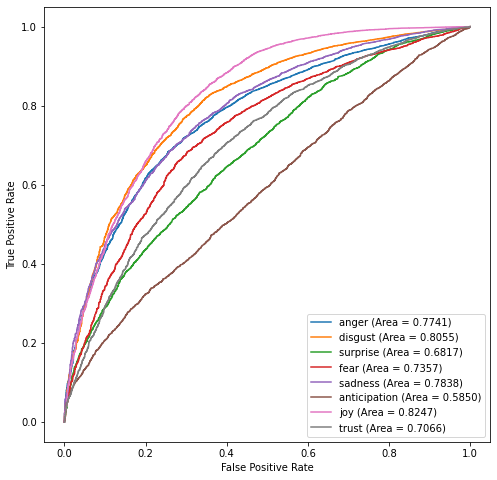

In [ ]:
# TDT on XED class + XED neutral for each of the 8 classes in XED.

%matplotlib inline
import matplotlib.pyplot as plt
import csv
import numpy as np
from collections import defaultdict
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.extmath import softmax

d = defaultdict(list)
for text, label_list in zip(nonneutral_texts, nonneutral_labels_raw):
  for label in label_list.split(','):
    d[int(label)].append(text)

xed_grouped = [[(t, 1) for t in neutral_texts] + [(t, 0) for t in texts] for (_, texts) in d.items()]

xed_tokenized = [tokenizer([t for t, _ in y], truncation=True, padding='longest', max_length=input_size) for y in xed_grouped]

es = [[tf.constant(e.data['input_ids']),
       tf.constant(e.data['attention_mask']),
       tf.constant(e.data['token_type_ids'])]
      for e in xed_tokenized]

def train_evaluate(t, train_label, run_count):
  num_labels = 2
  runs = []
  for i in range(run_count):
    bert = TFBertForSequenceClassification.from_pretrained(model_name,
                                                          num_labels=num_labels)
    bert = train(bert, t, train_label)
    runs.append([bert.predict(e)[0] for e in es])
  return transpose(runs)

runs = train_evaluate([x for x in t], tdt_train_labels_binary, 5)

class_names = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']

plt.figure(figsize=(8, 8))

def format_floats(l):
  return ', '.join(f'{x:.4f}' for x in l)

print(f"Model: {model_name}, initial learning rate = {init_lr}, input size = {input_size}, batch size = {batch_size_train}, epochs = {epochs}\n")

for label, true, preds in zip(d.keys(), [[l for _, l in g] for g in xed_grouped], runs):
  class_name = class_names[label-1]
  accuracy = [accuracy_score(true, p.argmax(-1)) for p in preds]
  weighted_f1 = [f1_score(true, p.argmax(-1), average='weighted') for p in preds]
  roc = [roc_curve(true, softmax(p)[:,1]) for p in preds]
  aucs = [auc(fpr, tpr) for fpr, tpr, _ in roc]
  max_i = aucs.index(max(aucs))
  print(f'Statistics for {class_name}')
  print('Accuracy: ', format_floats(accuracy))
  print('Weighted F-score: ', format_floats(weighted_f1))
  print('ROC AUC: ', format_floats(aucs))
  print(f'Average accuracy: {np.mean(accuracy):.4f}, standard deviation: {np.std(accuracy):.4f}')
  print(f'Average weighted F-score: {np.mean(weighted_f1):.4f}, standard deviation: {np.std(weighted_f1):.4f}')
  print(f'Average ROC AUC: {np.mean(aucs):.4f}, standard deviation: {np.std(aucs):.4f}')
  print()
  fpr, tpr, _ = roc[max_i]
  plt.plot(fpr, tpr, label=f'{class_name} (Area = {aucs[max_i]:.4f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()